## hammurabiX tutorial 01

### hammurabiX with given field models

This tutorial describes the basic usage of the python wrapper which depends on an XML parameter file. 

In [1]:
#NBVAL_CHECK_OUTPUT

import matplotlib
import numpy as np
import healpy as hp
import os
import sys
import hampyx as hpx
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### hampyx, the hammurabiX python wrapper

The Hampyx init function:

```
def __init__(self,
             xml_path=None,
             exe_path=None)
```

The path to the executable `exe_path` (upon the default input `None`) is searched automatically through the system environment (by taking the first executable target with key word `hamx` registered in `PATH`), while the path to the XML parameter file `xml_path` by default is searched automatically through the current working directory and the first match with `*.xml` will be taken.

Users can store different sets of `hammuarbiX` parameters in different `XML` files.

working directory is set as the same directory as this file, it relies on subprocess to fork `C++` routine and passing data through disk, and by doing so, it is not fast.

Notice that `hammurabiX` uses `XML` input parameter file, which may look like:

```
<root>
    ...
    <key1 tag1='content1'>
        ...
        <key2 tag21='content21' tag22='content22'/>
        ...
    </key1>
    ...
</root>
```
We highly recommend users to read the template_params.xml first, where sufficient captions have been provided.

methods/functions:

- Import class

```
In []: import hampyx as hpx
```

- Initialize instance/object

```
In []: object = hpx.Hampyx (exe_path, xml_path)
```

- Modify parameter value from base xml file to temp `XML` file

```
In []: object.mod_par (keychain=['key1','key2',...], attrib={'tag':'content'})
```

- Add new parameter with or without attributes.

```
In []: object.add_par (keychain=['key1','key2',...], subkey='keyfinal', attrib={'tag':'content'})
```

The new parameter subkey, will be added at the path defined by keychain.

- Delete parameter

```
In []: object.del_par (keychain=['key1','key2',...],opt='')
```

If additional argument opt='all', then all matching parameters will be deleted.

The strings 'key1', 'key2', etc represent the path to the desired parameter, going through the `XML` file.

The "tag" is the label for the parameter: eg. "Value" or "cue" or "type".

The "content" is the content under the tag: eg. the string for the tag "filename"

- Look through the parameter tree in python

```
In []: object.print_par(keychain=['key1','key2',...])
```

This will return the current value of the parameter in the `XML` associated with the path "key1/key2/.../keyfinal/".

- Run the executable

```
In []: object(verbose=True/False)
```

If additional verbose=True (by default is False) hampyx_run.log and hampyx_err.log will be dumped to disk
notice that dumping logs is not thread safe, use quiet mode in threading.

After this main routine, object.sim_map will be filled with simulation outputs from hammurabiX
the structure of object.sim_map contains arrays under entries:

(we give up nested dict structure for the convenience of Bayesian analysis)

```
object.sim_map[('sync',str(freq),str(Nside),'I')] # synchrotron intensity map at 'frequency' 
object.sim_map[('sync',str(freq),str(Nside),'Q')] # synchrotron Q map at 'frequency' 
object.sim_map[('sync',str(freq),str(Nside),'U')] # synchrotron U map at 'frequency'
object.sim_map[('fd','nan',str(Nside),'nan')] # Faraday depth map
object.sim_map[('dm','nan',str(Nside),'nan')] # dispersion measure map
```

#### In the following we will present how to use above functions

#### initialize

In [2]:
#NBVAL_CHECK_OUTPUT

xmlpath = '../templates/params_template.xml'
sim = hpx.Hampyx(xml_path=xmlpath)

# print root->observable
sim.print_par(['obsio'])

obsio {}
|-->  dm {'filename': 'dm.bin', 'nside': '8'}
|-->  faraday {'filename': 'fd.bin', 'nside': '64'}
|-->  sync {'freq': '30', 'filename': 'sync_30.bin', 'nside': '16'}
|-->  sync {'freq': '1.4', 'filename': 'sync_1.4.bin', 'nside': '32'}


- once the `XML` parameter file is read in, the `XML` tree is deep copied and so the following modifications does not affect the external file, unless explicit write the tree to the disk

#### use `del_par` to remove dust emission outputs

In [3]:
#NBVAL_CHECK_OUTPUT

sim.del_par(['obsio','sync'],True)
sim.print_par(['obsio'])

obsio {}
|-->  dm {'filename': 'dm.bin', 'nside': '8'}
|-->  faraday {'filename': 'fd.bin', 'nside': '64'}


#### use `mod_par` to change synchrotron emission output resolution

In [4]:
#NBVAL_CHECK_OUTPUT

sim.mod_par(['obsio','faraday'],{'nside':'2'})
sim.print_par(['obsio'])

obsio {}
|-->  dm {'filename': 'dm.bin', 'nside': '8'}
|-->  faraday {'filename': 'fd.bin', 'nside': '2'}


#### use `add_par` to add another synchrotron emission output

In [5]:
#NBVAL_CHECK_OUTPUT

sim.add_par(['obsio'],'sync',{'freq':'10','filename':'sync_10.bin','nside':'8'})
sim.print_par(['obsio'])

obsio {}
|-->  dm {'filename': 'dm.bin', 'nside': '8'}
|-->  faraday {'filename': 'fd.bin', 'nside': '2'}
|-->  sync {'freq': '10', 'filename': 'sync_10.bin', 'nside': '8'}


- upon adding an existed key with existed attributes, a ValueError will be raised

#### check field i/o settings

In [6]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['fieldio'])

fieldio {}
|-->  bfield {'read': '0', 'write': '0', 'filename': 'bfield.bin'}
|-->  tefield {'read': '0', 'write': '0', 'filename': 'tefield.bin'}
|-->  crefield {'read': '0', 'write': '0', 'filename': 'crefield.bin'}


#### check grid settings

In [7]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['grid'])

grid {}
|-->  observer {}
|-->  bfield {}
|-->  tefield {}
|-->  crefield {}
|-->  shell {'type': 'auto'}


- grid->observer hosts the galactic-centric location of the observer (in kpc unit)

In [8]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['grid','observer'])

observer {}
|-->  x {'value': '-8.3'}
|-->  y {'value': '0'}
|-->  z {'value': '0.006'}


- shell hosts the LoS integral settings

In [9]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['grid','shell'])
print()
sim.print_par(['grid','shell','auto'])
print()
sim.print_par(['grid','shell','manual'])

shell {'type': 'auto'}
|-->  auto {}
|-->  manual {}
|-->  oc_r_min {'value': '0.0'}
|-->  oc_r_max {'value': '30.0'}
|-->  gc_r_min {'value': '0.0'}
|-->  gc_r_max {'value': '20.0'}
|-->  gc_z_min {'value': '-10.0'}
|-->  gc_z_max {'value': '10.0'}
|-->  oc_r_res {'value': '0.01'}

auto {}
|-->  shell_num {'value': '1'}
|-->  nside_sim {'value': '32'}

manual {}
|-->  cut {'value': '0.5'}
|-->  nside_sim {'value': '32'}
|-->  nside_sim {'value': '64'}


#### check magnetic field settings

In [10]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['bmodel'])

bmodel {}
|-->  unif {'cue': '1'}
|-->  lsa {'cue': '0'}
|-->  jaffe {'cue': '0'}
|-->  es {'cue': '0', 'seed': '0'}
|-->  mhd {'cue': '0', 'seed': '0'}


#### check thermal electron field settings

In [11]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['temodel'])

temodel {}
|-->  unif {'cue': '1'}
|-->  ymw16 {'cue': '0'}
|-->  dft {'cue': '0', 'seed': '0'}


#### check cosmic ray electron field settings

In [12]:
#NBVAL_CHECK_OUTPUT

sim.print_par(['cremodel'])

cremodel {}
|-->  unif {'cue': '1'}
|-->  pwrlaw {'cue': '0'}


#### users are recommended to check all parameters to make sure they are set as expected, then we can start to run the simulation routine

- the optional input argument verbose=True/False determines whether the log of hammurabiX execution will be printed

In [13]:
#NBVAL_CHECK_OUTPUT

sim()

- get the output entries

In [14]:
#NBVAL_CHECK_OUTPUT

for key in sim.sim_map.keys():
    print (key)

('dm', 'nan', '8', 'nan')
('fd', 'nan', '2', 'nan')
('sync', '10', '8', 'I')
('sync', '10', '8', 'Q')
('sync', '10', '8', 'U')


- illustrate simulated map behind one entry

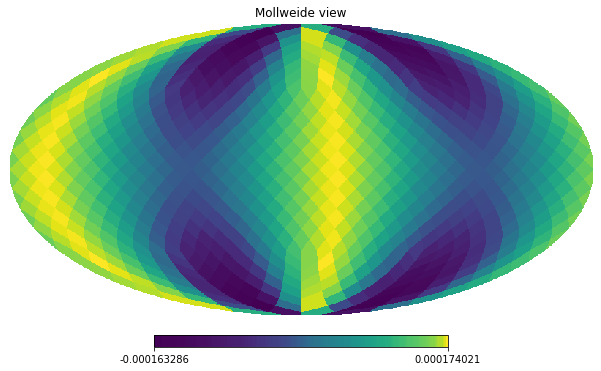

In [15]:
#NBVAL_CHECK_OUTPUT

out_sync_Q = sim.sim_map[('sync', '10', '8', 'Q')]
hp.mollview(out_sync_Q,norm='hist')

### play with mask map

for simulating partial-sky maps and saving computing time, hammurabi X can read in a single mask map provided in HEALPix format, this external mask map once read in, will be applied to all simulation outputs.

Notice that, the mask map resolution is read in as the pivot masking resolution, which means it DOES NOT defines the output resolution, so the output results will ONLY ensure that the un-masked area is included, sometimes, the masked area near the masking boudary will also be calculated due to the resolution difference.

faction:  0.32902018229166663


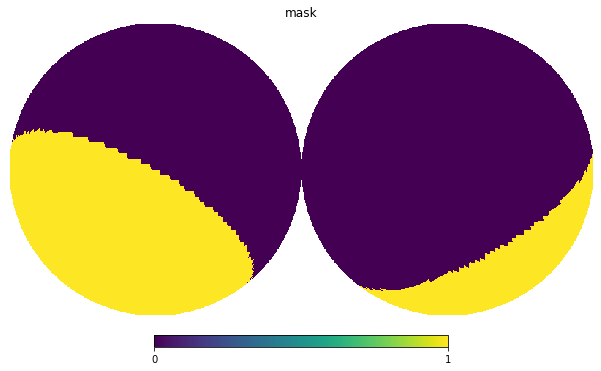

In [16]:
#NBVAL_CHECK_OUTPUT

# mask resolution
mask_nside = 32

def mask_map_prod(_nside,_clon,_clat,_sep,_external_mask=None):
    _c = np.pi/180
    def hav(_theta):
        return 0.5-0.5*np.cos(_theta)
    tmp = np.ones(hp.nside2npix(_nside),dtype=np.float64)
    count = 0
    for _ipix in range(len(tmp)):
        lon,lat = hp.pix2ang(_nside,_ipix,lonlat=True)
        # iso-angle separation
        if((hav(np.fabs(_clat-lat)*_c)+np.cos(_clat*_c)*np.cos(lat*_c)*hav(np.fabs(_clon-lon)*_c))>hav(_sep*_c)):
            count = count + 1
            tmp[_ipix] = False
    print ('faction: ', (1 - count/(12*_nside*_nside)))
    return tmp

# prepare mask
cust_tmask = mask_map_prod(mask_nside, 30, 20, 70)
hp.orthview(cust_tmask, rot=[0,90], min=0, max=1, title='mask')
if os.path.isfile('mask_tutorial_01.bin'):
    os.remove('mask_tutorial_01.bin')
cust_tmask.tofile('mask_tutorial_01.bin')

**modify the mask entry**

In [17]:
#NBVAL_CHECK_OUTPUT

sim.add_par(['obsio'],'mask',{'filename': 'mask_tutorial_01.bin', 'nside': '32'})
sim.print_par(['obsio','mask'])

mask {'filename': 'mask_tutorial_01.bin', 'nside': '32'}


**rerun the simulation**

In [18]:
#NBVAL_CHECK_OUTPUT

sim()

**the masked pixels should have value 0.0**

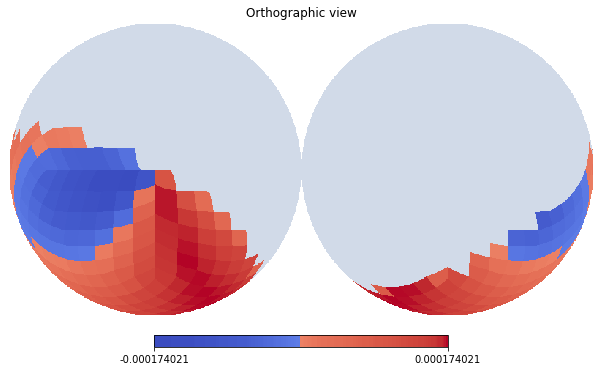

In [19]:
#NBVAL_CHECK_OUTPUT

out_sync_Q = sim.sim_map[('sync', '10', '8', 'Q')]
absmax = np.max(out_sync_Q)
hp.orthview(out_sync_Q, rot=[0,90], norm='hist',max=absmax,min=-absmax,cmap='coolwarm')

### play with random fields

In [20]:
sim.del_par(['obsio','mask'], True)
sim.mod_par(['bmodel','es'], {'cue': str(1)})
sim.mod_par(['bmodel','es','rms'], {'value': str(2.0)})

sim.del_par(['bmodel','lsa'], True)
sim.del_par(['bmodel','jaffe'], True)
sim.del_par(['bmodel','mhd'], True)
sim.print_par(['bmodel'])
sim.print_par(['bmodel','es'])
sim.print_par(['bmodel','unif'])

bmodel {}
|-->  unif {'cue': '1'}
|-->  es {'cue': '1', 'seed': '0'}
es {'cue': '1', 'seed': '0'}
|-->  rms {'value': '2.0'}
|-->  k0 {'value': '10.0'}
|-->  k1 {'value': '0.1'}
|-->  a0 {'value': '1.7'}
|-->  a1 {'value': '0.0'}
|-->  rho {'value': '1.0'}
|-->  r0 {'value': '8.0'}
|-->  z0 {'value': '1.0'}
unif {'cue': '1'}
|-->  bp {'value': '2.0'}
|-->  bv {'value': '0.0'}
|-->  l0 {'value': '70'}


**rerun the simulation**

In [21]:
#NBVAL_CHECK_OUTPUT

sim()

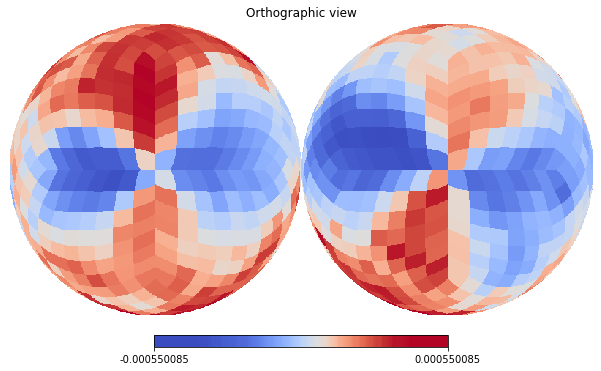

In [22]:
out_sync_Q = sim.sim_map[('sync', '10', '8', 'Q')]
absmax = np.max(out_sync_Q)
hp.orthview(out_sync_Q, rot=[0,90], norm='hist',max=absmax,min=-absmax,cmap='coolwarm')

clean up

In [23]:
if os.path.isfile('mask_tutorial_01.bin'):
    os.remove('mask_tutorial_01.bin')
if os.path.isfile('err.log'):
    os.remove('err.log')
if os.path.isfile('run.log'):
    os.remove('run.log')

end